In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    primeira = 1
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        print(f"Tempo: {t}")
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        if isinstance(t, float):
             rho_vector[0][int(round(t,0))+r] = pt[0][0]
             rho_vector[1][int(round(t,0))+r] = pt[0][1]
             rho_vector[2][int(round(t,0))+r] = pt[1][0]
             rho_vector[3][int(round(t,0))+r] = pt[1][1]
             r += 1
        else:
            rho_vector[0][t] = pt[0][0]
            rho_vector[1][t] = pt[0][1]
            rho_vector[2][t] = pt[1][0]
            rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        # if 1/2*(1+rt[2][0]) > 0.9995:
        #     distance_vector.pop()
        #     fx_vector.pop()
        #     fy_vector.pop()
        #     fz_vector.pop()
        #     fid_vector.pop()
        #     fid_autores.pop()
        #     resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        #     u[0] = resultado_algoritmo_genetico[0]
        #     u[1] = resultado_algoritmo_genetico[1]
        #     u[2] = resultado_algoritmo_genetico[2]
        while 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
            print(f"Processo de infactibilidade")
            print(f"Porta: {fid_autores[-1]}")
            print(f"Estados: {fid_vector[-1]}")
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            aas[-1] = ((u[0],u[1],u[2]))
        
        if t <= 70:
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
        elif t > 70:
            h = 0.0005
            if primeira:
                while D > 5*10**(-3) or 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
                    resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
                    u[0] = resultado_algoritmo_genetico[0]
                    u[1] = resultado_algoritmo_genetico[1]
                    u[2] = resultado_algoritmo_genetico[2]
                    a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
                    rt = np.dot(Uto, r0)
                    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
                    fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
                    fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
                    aas[-1] = ((u[0],u[1],u[2]))
                    D = np.linalg.norm(Uto-Uf)**2
                    distance_vector[-1] = D
                    print(f"Distância: {D}")
                    print(f"Porta: {fid_autores[-1]}")
                    print(f"Estados: {fid_vector[-1]}")
                    Ut = Uto
                    t += 0.5
                t = 71
                t += 0.5
                primeira = 0
            else:
                print(f"Alcançou-se um valor desejável")
                resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
                u[0] = resultado_algoritmo_genetico[0]
                u[1] = resultado_algoritmo_genetico[1]
                u[2] = resultado_algoritmo_genetico[2]
                t += 0.5
        Ut = Uto

    print(f"O rho gerado foi: {pt}") 
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Tempo: 0


/tmp/ipykernel_9587/116918231.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  f = -a*SA-h*(SB/SA)


Tempo: 1
Tempo: 2
Tempo: 3
Tempo: 4
Tempo: 5
Tempo: 6
Tempo: 7
Tempo: 8
Tempo: 9
Tempo: 10
Tempo: 11
Tempo: 12
Tempo: 13
Tempo: 14
Tempo: 15
Tempo: 16
Tempo: 17
Tempo: 18
Tempo: 19
Processo de infactibilidade
Porta: 0.7356852759891671
Estados: (1.0022861161185088-3.9178869389895e-06j)
Tempo: 20
Processo de infactibilidade
Porta: 0.7341574351487342
Estados: (1.0014234714561987-3.1040311732351766e-05j)
Processo de infactibilidade
Porta: 0.7344119372681842
Estados: (1.00239353993318+2.1030185331835738e-05j)
Tempo: 21
Tempo: 22
Processo de infactibilidade
Porta: 0.9164157791725577
Estados: (1.003272225363755+2.1535512768491313e-05j)
Processo de infactibilidade
Porta: 0.9096640071279835
Estados: (1.0004021759765267+3.727746758892147e-05j)
Tempo: 23
Processo de infactibilidade
Porta: 0.9150545248646517
Estados: (1.0031237295589832-1.974269381502166e-06j)
Tempo: 24
Tempo: 25
Tempo: 26
Processo de infactibilidade
Porta: 0.9979528193379207
Estados: (1.0053243375195153-4.5143636580656125e-06j)
T

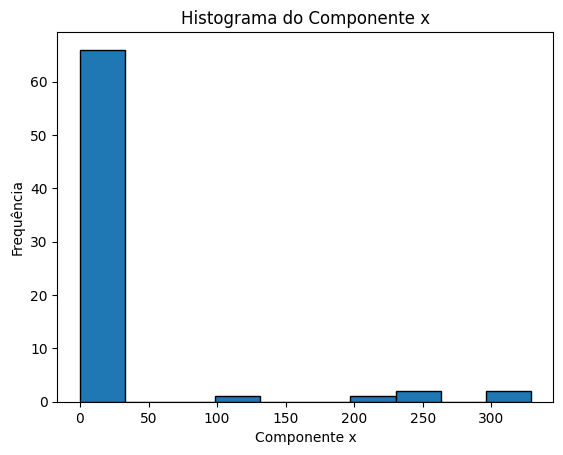

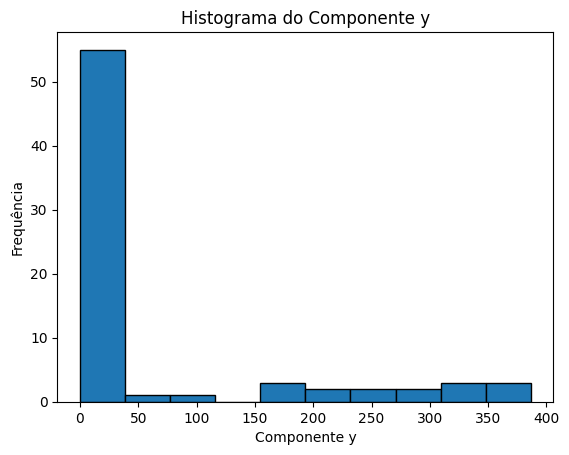

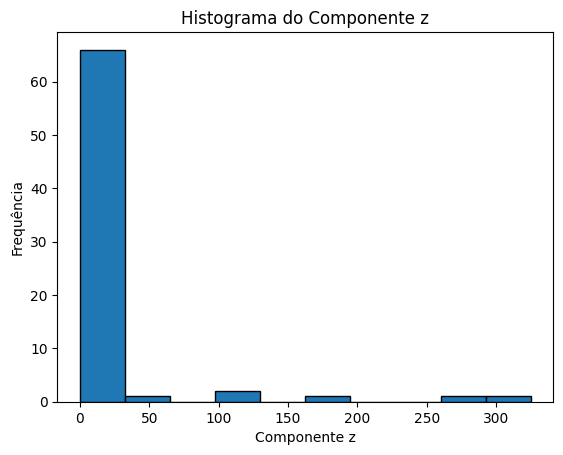

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9992361290451021
Estados: (0.9988634887313701-8.186468715948622e-08j)
Distância: 3.0419551150105736e-05
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[np.clongdouble('0.33801140224060703085+0.00012408718757351242713j'),
 np.clongdouble('0.36316992594114548074-0.00010535003464925868281j'),
 np.clongdouble('0.40991173267695429626-8.862286293620201702e-06j'),
 np.clongdouble('0.40997572025365690764+1.2550106093398163741e-05j'),
 np.clongdouble('0.41133819817702841715-0.00021927171758173422758j'),
 np.clongdouble('0.41370191189223488932-4.033400846969268613e-05j'),
 np.clongdouble('0.45231324616770006474-8.929241362564526346e-05j'),
 np.clongdouble('0.45221710621837076205+0.00018480242688718132843j'),
 np.clongdouble('0.62696443650021402766+0.00034798881529532653058j'),
 np.clongdouble('0.7820527814985115997+6.9556015492476894014e-05j'),
 np.clongdouble('0.7817629091620271-0.00013319870835612398546j'),
 np.clongdouble('0.8919727318969702737-1.24726140061480571315e-05j'),
 np.clongdouble('0.93953633769758933595-1.8960971492952038912e-05j'),
 np.clongdouble('0.98758350227188863033-6.3444294901350949268e-06j'),
 np.clongdouble('0.999974043

In [23]:
fid_autores

[np.float64(0.33332205533344106),
 np.float64(0.3139728923181245),
 np.float64(0.27625030997108047),
 np.float64(0.2762445603816671),
 np.float64(0.25512270281549987),
 np.float64(0.2547885060686432),
 np.float64(0.2545323790748439),
 np.float64(0.25240513612248844),
 np.float64(0.3030974640908379),
 np.float64(0.41830474780996263),
 np.float64(0.4182933847506766),
 np.float64(0.558092857790404),
 np.float64(0.6580060999357936),
 np.float64(0.7140217164751146),
 np.float64(0.7290478243537525),
 np.float64(0.7290284697923742),
 np.float64(0.7300783067164146),
 np.float64(0.7300590628925986),
 np.float64(0.730039685500917),
 np.float64(0.7308760102394105),
 np.float64(0.9090144853628429),
 np.float64(0.9092154089908133),
 np.float64(0.9091916309596072),
 np.float64(0.9859912595301695),
 np.float64(0.9860231241939789),
 np.float64(0.9860119485801565),
 np.float64(0.9974360483012111),
 np.float64(0.9974099353897246),
 np.float64(0.9973950437349292),
 np.float64(0.9973685700010922),
 np.flo

In [24]:
rho_vector

array([[0.33801142+0.j        , 0.36311862+0.j        ,
        0.40973944+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.47302231+0.j        , 0.47308897-0.0920216j ,
        0.47308319-0.13804412j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.47302231+0.j        , 0.47308897+0.0920216j ,
        0.47308319+0.13804412j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.66198858+0.j        , 0.63688138+0.j        ,
        0.59026056+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[np.float64(7.9998646639012945),
 np.float64(7.751104480683673),
 np.float64(7.115865668998753),
 np.float64(7.115805708821641),
 np.float64(6.470178863546434),
 np.float64(6.452763029040283),
 np.float64(6.437604021029296),
 np.float64(5.720117527108734),
 np.float64(4.421443646592224),
 np.float64(3.1709001294343366),
 np.float64(3.1708594733515088),
 np.float64(2.165778552197563),
 np.float64(1.5860443826569823),
 np.float64(1.2990072818244245),
 np.float64(1.2514563378096268),
 np.float64(1.2514386271442608),
 np.float64(1.246057123452267),
 np.float64(1.2460387952226684),
 np.float64(1.246021140971737),
 np.float64(1.22173587119222),
 np.float64(1.2252260402380244),
 np.float64(0.41796428699650423),
 np.float64(0.3901473778338456),
 np.float64(0.39319091787820604),
 np.float64(0.10790097766453208),
 np.float64(0.10783776358628919),
 np.float64(0.07797403098376661),
 np.float64(0.0617751852290674),
 np.float64(0.03972856461666855),
 np.float64(0.061724960205558226),
 np.float64(0.0

In [26]:
fx_vector

[np.float64(0.0),
 400,
 400,
 np.float64(-0.0052631344494887015),
 np.float64(7.317896437090536),
 np.float64(6.393466969916452),
 np.float64(-0.0036183316721318764),
 np.float64(-0.002638747861022341),
 400,
 400,
 np.float64(-5.1141370845974064e-05),
 400,
 np.float64(264.032583682579),
 np.float64(0.002937470699256407),
 np.float64(0.004344982332133873),
 np.float64(0.003730521036450104),
 np.float64(0.0037271345483818955),
 np.float64(0.0037279922473237278),
 np.float64(0.003728814011322593),
 np.float64(13.178957836057906),
 np.float64(35.133102379772275),
 np.float64(0.0019384976111365426),
 np.float64(22.505576287375064),
 np.float64(37.83306211560821),
 np.float64(0.00042560919410661725),
 np.float64(0.0004263465549667079),
 np.float64(-59.640005158974496),
 np.float64(0.00014920841227751292),
 np.float64(39.46219502926325),
 np.float64(0.00015049494443117794),
 np.float64(0.00015128504611200272),
 np.float64(-1.8969876295491794e-05),
 np.float64(34.52894444931979),
 np.float6

In [27]:
fy_vector

[np.float64(329.9698891161809),
 np.float64(-0.5538543792186792),
 np.float64(0.016959836994521797),
 np.float64(0.016865050367368236),
 np.float64(0.03768243048113333),
 np.float64(-0.490003925465061),
 np.float64(-66.56737394706519),
 np.float64(-0.015064589974257105),
 np.float64(-0.006778431744057437),
 np.float64(-0.0011509591077616492),
 np.float64(-0.0010939713316553499),
 np.float64(-0.002047518775968553),
 np.float64(-0.0008974282039381478),
 np.float64(-145.14886364459517),
 np.float64(57.896503667447405),
 np.float64(-0.008224534056776079),
 np.float64(-0.008240540243039102),
 np.float64(-0.012000731959468013),
 np.float64(-0.008246473743222816),
 np.float64(-0.0036745821699736597),
 np.float64(-0.005505150029659749),
 np.float64(-0.008276339950349694),
 np.float64(-0.0036098706965736575),
 np.float64(-20.769033304381903),
 np.float64(-1.7371106891979535),
 np.float64(-0.013505946466526812),
 np.float64(0.001394358776519876),
 np.float64(0.36017991033804614),
 np.float64(0.0

In [28]:
fz_vector

[np.float64(0.0),
 np.float64(-0.02888061982305414),
 np.float64(-0.010573515218992822),
 np.float64(-0.010489675940923242),
 400,
 np.float64(-0.007972020429212771),
 np.float64(-0.006783111407760763),
 400,
 np.float64(-0.001687427228296602),
 np.float64(-6.061699742911551e-05),
 np.float64(-5.439474375833614e-05),
 np.float64(0.00047681392234085644),
 np.float64(0.0005495936260147516),
 np.float64(0.0004974667408116524),
 np.float64(0.000442542176968781),
 np.float64(0.000496651390350348),
 np.float64(1.8649410077722117),
 np.float64(0.0004977916523868607),
 np.float64(0.0004978753171188515),
 np.float64(0.0004893011710459843),
 np.float64(0.0004993136364553698),
 np.float64(0.5614081224570374),
 np.float64(0.00045757619869421864),
 np.float64(0.0004786736395253179),
 np.float64(0.0002690285828067968),
 np.float64(0.07896864142077872),
 np.float64(-0.0001528787738437009),
 np.float64(0.00015254895148751748),
 np.float64(-7.964845367062641e-05),
 np.float64(0.00015405423594537596),
 

In [29]:
a

[(np.float64(0.0), np.float64(329.9698891161809), np.float64(0.0)),
 (np.float64(114.57320836693401),
  np.float64(0.13969746797212293),
  np.float64(0.0)),
 (np.float64(328.74611633248713), np.float64(0.0), np.float64(0.0)),
 (np.float64(6.722617965898583e-13),
  np.float64(0.0),
  np.float64(2.1328343662375376e-164)),
 (np.float64(0.3676359722283178),
  np.float64(0.0),
  np.float64(275.6418913676772)),
 (np.float64(0.320347892462055),
  np.float64(0.3231486513523906),
  np.float64(0.0)),
 (np.float64(0.0), np.float64(84.13461819284987), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(324.9612808392837)),
 (np.float64(322.6051971538249), np.float64(0.0), np.float64(0.0)),
 (np.float64(261.81059227231526), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
 (np.float64(237.4999311000298), np.float64(0.0), np.float64(0.0)),
 (np.float64(220.37454543882404), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(175.087845